# WIDS Predict Hospital Fatality

**Table of Contents:**

1. Import Libriaries/packages
2. Explore Data
3. Preprocess data (missing values, collinearity (correlation), scale)
4. Model http://localhost:8888/lab#Convert-to-numerical-via-labelencoding-or-onehotencoding-#revisit
5. Evaluate


In [1]:
from datetime import datetime

In [2]:
start_time = datetime.now()

In [3]:
import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./input\samplesubmission.csv
./input\solution_template.csv
./input\training_v2.csv
./input\unlabeled.csv
./input\WiDS Datathon 2020 Dictionary.csv


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder



# additional experiement packages
import missingno as msno

%matplotlib inline

## Load Data

In [5]:
# loading dataset 
training = pd.read_csv("./input/training_v2.csv")
solution_template = pd.read_csv("./input/solution_template.csv")
samplesubmission = pd.read_csv("./input/samplesubmission.csv")
unlabeled = pd.read_csv("./input/unlabeled.csv")
dictionary = pd.read_csv("./input/WiDS Datathon 2020 Dictionary.csv")

In [6]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [7]:
solution_template.head()

,encounter_id,hospital_death
0,2,NaN
1,5,NaN
2,7,NaN
3,8,NaN
4,10,NaN


In [8]:
samplesubmission.head()

,encounter_id,hospital_death
0,2,0.500
1,5,0.200
2,7,0.001


In [9]:
unlabeled.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,Caucasian,M,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.500595,1,Caucasian,F,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
2,7,101458,86,NaN,66.0,32.518596,1,African American,M,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,8,48067,163,NaN,64.0,20.798520,0,Caucasian,M,182.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
4,10,25865,59,NaN,56.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [10]:
unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39308 entries, 0 to 39307
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(171), int64(7), object(8)
memory usage: 55.8+ MB


In [11]:
dictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None


## Explore Data:

1. One way plots (bar and dot plot)

In [12]:
training.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [13]:
x, y, hue = "index", "hospital_death", "sex"
hue_order = ["Male", "Female"]

(training.gender
 .value_counts(normalize=True)
 .rename({'gender': 'proportion'}, axis=0)
 )

M    0.539536
F    0.460464
Name: gender, dtype: float64

In [14]:
training['gender_missing'] = training.gender.copy()

In [15]:
training['gender_missing'] = training.gender_missing.fillna('Missing')

In [16]:
training.gender_missing.value_counts()

M          49469
F          42219
Missing       25
Name: gender_missing, dtype: int64

In [17]:
training['gender_missing'].value_counts(normalize=True)

M          0.539389
F          0.460338
Missing    0.000273
Name: gender_missing, dtype: float64

In [18]:
training.groupby('gender_missing').mean()['hospital_death']

gender_missing
F          0.088373
M          0.084417
Missing    0.320000
Name: hospital_death, dtype: float64

In [19]:
training.groupby('gender').mean()['hospital_death']

gender
F    0.088373
M    0.084417
Name: hospital_death, dtype: float64

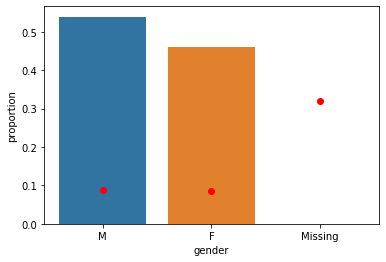

In [20]:
(training['gender_missing']
.value_counts(normalize=True)
.reset_index()
.rename(columns={'index': 'gender', 'gender_missing': 'proportion'})
.pipe((sns.barplot, 'data'), x='gender', y='proportion')
)

plt.plot(training.groupby('gender_missing').mean()['hospital_death'], 'ro')



### Calculate correlation matrix

In [21]:
%%time

corr_matrix = training.corr().abs

Wall time: 7.15 s


In [22]:
training_3 = training.copy()

In [23]:
training_3.drop(training_3.columns[training_3.apply(lambda col: col.isnull().sum() / training_3.shape[0] > 0.5)], axis = 1)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,M
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,F
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F


In [24]:
training.dtypes.value_counts()

float64    170
object       9
int64        8
dtype: int64

In [25]:
training['patient_id'].nunique()

91713

In [26]:
training['age'].describe()

count    87485.000000
mean        62.309516
std         16.775119
min         16.000000
25%         52.000000
50%         65.000000
75%         75.000000
max         89.000000
Name: age, dtype: float64

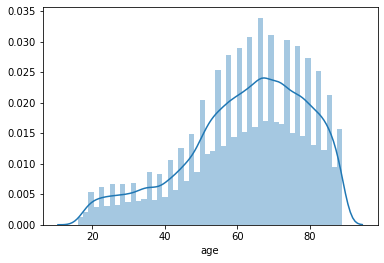

In [27]:
sns.distplot(training['age'].dropna())

## Drop useless fields

In [28]:
#drop these columns

id_columns_to_drop = training.filter(regex='id$',axis=1).columns

In [29]:
training.drop(columns=id_columns_to_drop, inplace=True)

In [30]:
def drop_id_fields(df):
    id_columns_to_drop = df.filter(regex='id$',axis=1).columns
    df.drop(columns=id_columns_to_drop, inplace=True)
    return df

## Missing values

3 Types of Missing values:

1. MCAR Missing completely at random
    - This is generally ok to impute mean, mode or median.
    
The two below must be treated with caution. When there is a dependance with the target and other variables with why it is missing then there may be an improvement if a model is used to impute the missing values.

2. MAR Missing at random
3. MNAR Missing not at random

Columnwise

Text(0, 0.5, 'count of fields')

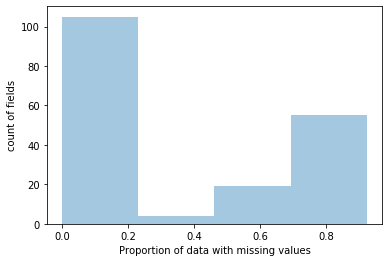

In [31]:
sns.distplot((training.isnull().sum()/training.shape[0]).sort_values(ascending=False), kde=False)

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of fields')

Text(0, 0.5, 'count of fields')

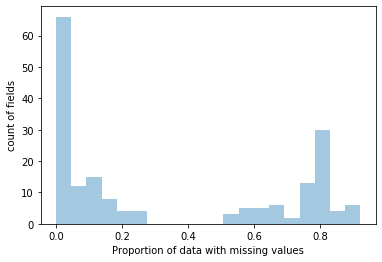

In [32]:
sns.distplot((training.isnull().sum()/training.shape[0]).sort_values(ascending=False), kde=False, bins=20
            )

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of fields')

Based on the plot below, we have decided to make the cut off for missing values at 40%

In [33]:
list_to_drop = training.columns[(training.isnull().sum()/training.shape[0])>0.1]

In [34]:
training.drop(columns=list_to_drop, inplace=True)

In [35]:
def drop_missing_columns(df):
    list_to_drop = df.columns[(df.isnull().sum()/df.shape[0])>0.1]
    df.drop(columns=list_to_drop, inplace=True)
    return df

In [36]:
training.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,0,68.0,22.73,0,Caucasian,M,180.3,Floor,admit,CTICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,0,77.0,27.42,0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,0,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,0,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M


Missing values Row-wise

Text(0, 0.5, 'count of rows')

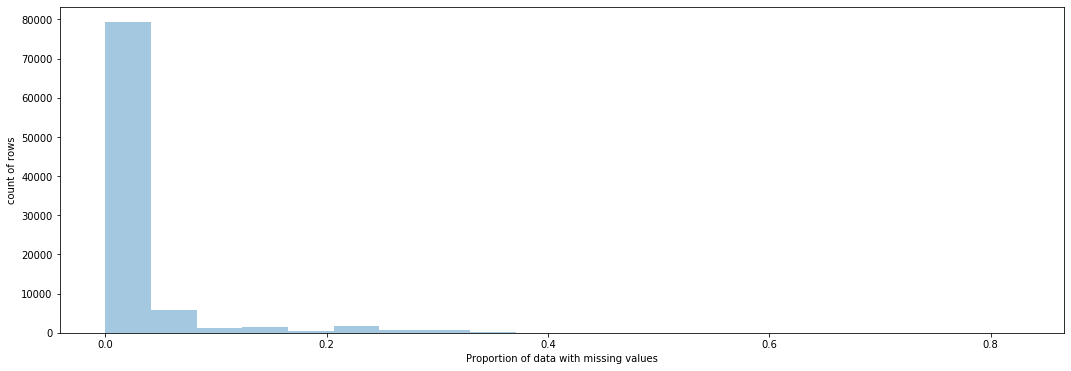

In [37]:
plt.figure(figsize=(18,6))

sns.distplot((training.isnull().sum(axis=1)/training.shape[1]).sort_values(ascending=False), kde=False, bins=20
            )

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of rows')

In [38]:
training[(training.isnull().sum(axis=1)/training.shape[1])>0.1]

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
4,0,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
19,0,39.0,37.010278,1,NaN,M,177.8,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,M
46,1,64.0,16.980389,0,Caucasian,M,180.3,Operating Room / Recovery,admit,Neuro ICU,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Neurological,Neurologic,M
51,0,53.0,NaN,1,Caucasian,F,162.6,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Undefined diagnoses,F
52,0,73.0,28.058219,1,Caucasian,M,177.8,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91704,0,38.0,32.992923,0,Caucasian,M,177.8,Accident & Emergency,admit,Cardiac ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91705,0,67.0,28.876843,0,African American,M,182.9,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91707,0,NaN,33.933518,0,Caucasian,F,152.0,Accident & Emergency,admit,Med-Surg ICU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F
91710,0,48.0,27.236914,0,Caucasian,M,170.2,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M


In [39]:
rows_to_drop = training[(training.isnull().sum(axis=1)/training.shape[1])>0.2].index

In [40]:
training.drop(rows_to_drop, inplace=True)

In [41]:
def drop_missing_rows(df):
    rows_to_drop = df[(df.isnull().sum(axis=1)/df.shape[1])>0.2].index
    df.drop(rows_to_drop, inplace=True)
    return df

In [42]:
import missingno as msno

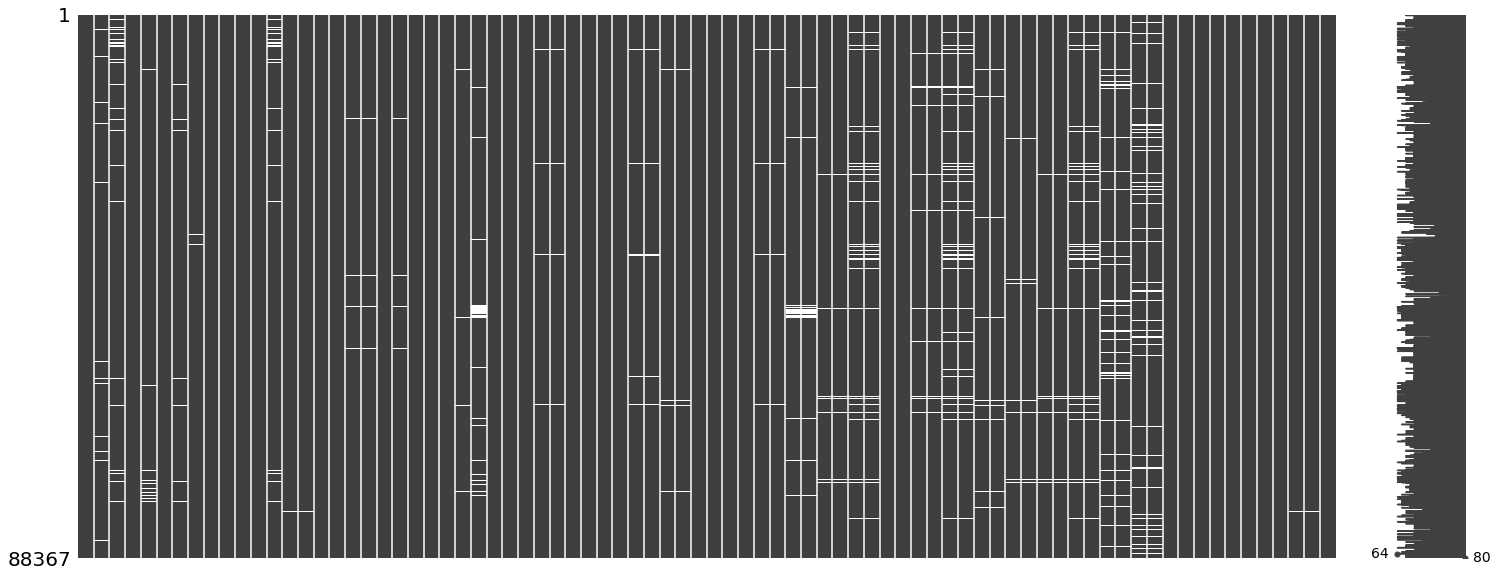

In [43]:
msno.matrix(training)

In [44]:
categorical = training.select_dtypes('object')

In [45]:
numerical = training.select_dtypes(exclude='object')

## fill nas

In [46]:
training.dtypes.value_counts()

float64    68
object      8
int64       4
dtype: int64

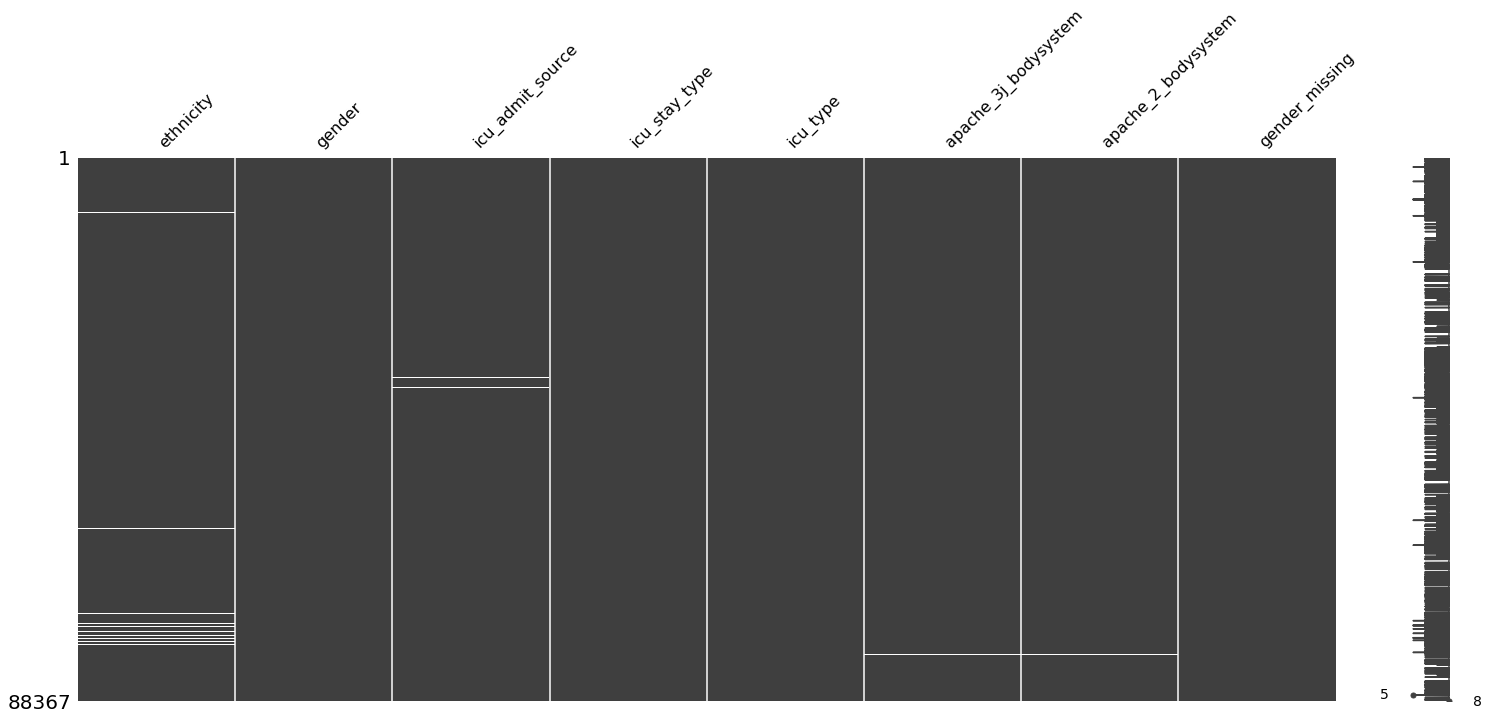

In [47]:
msno.matrix(categorical)

In [48]:
categorical.isnull().sum()

ethnicity               1255
gender                    23
icu_admit_source          95
icu_stay_type              0
icu_type                   0
apache_3j_bodysystem     821
apache_2_bodysystem      821
gender_missing             0
dtype: int64

In [49]:
from sklearn.impute import SimpleImputer

## categorical imputer

cat_imp = SimpleImputer(strategy="most_frequent")

In [50]:
training_backup = training.copy()

In [51]:
training[categorical.columns] = cat_imp.fit_transform(categorical)

In [52]:
training[categorical.columns].isnull().sum()

ethnicity               0
gender                  0
icu_admit_source        0
icu_stay_type           0
icu_type                0
apache_3j_bodysystem    0
apache_2_bodysystem     0
gender_missing          0
dtype: int64

In [53]:
# imputer numerical features

num_imp = SimpleImputer(strategy="mean")

training[numerical.columns] = num_imp.fit_transform(numerical)



In [54]:
training[numerical.columns].isnull().sum()

hospital_death                 0
age                            0
bmi                            0
elective_surgery               0
height                         0
                              ..
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
Length: 72, dtype: int64

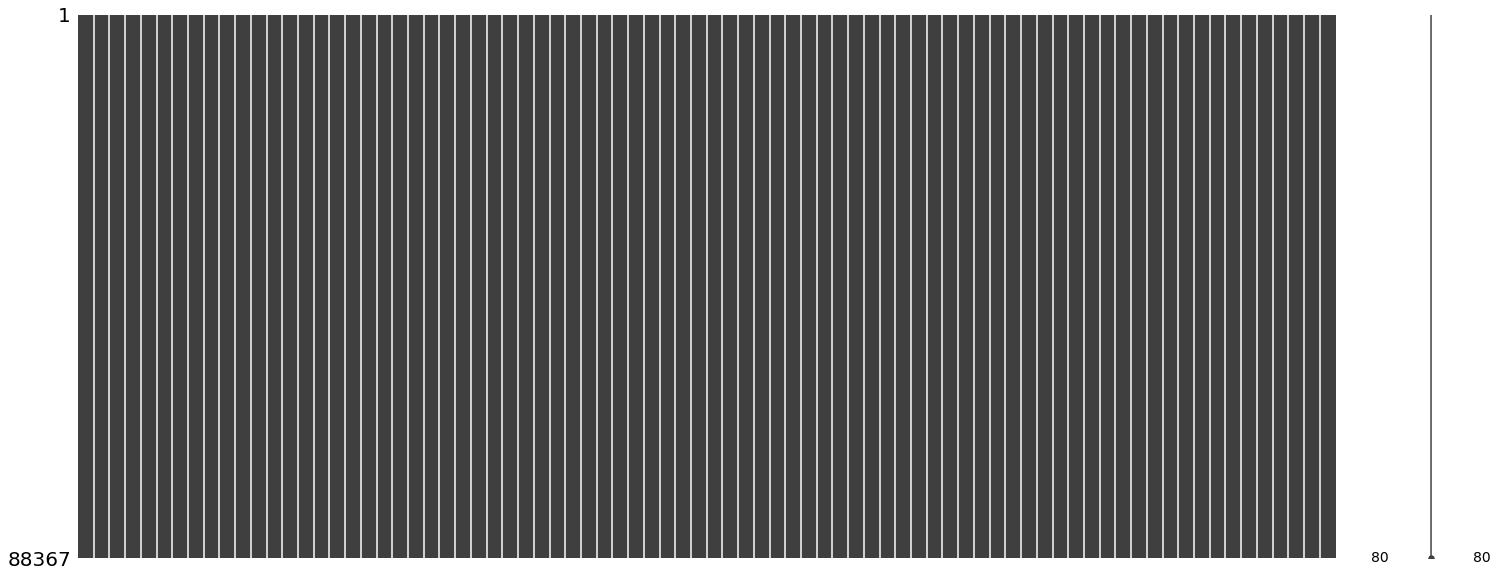

In [55]:
msno.matrix(training)

## Multicollinearity - remove columns that are highly correlated with each other

In [56]:
corr_matrix = training.corr().abs()

In [57]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

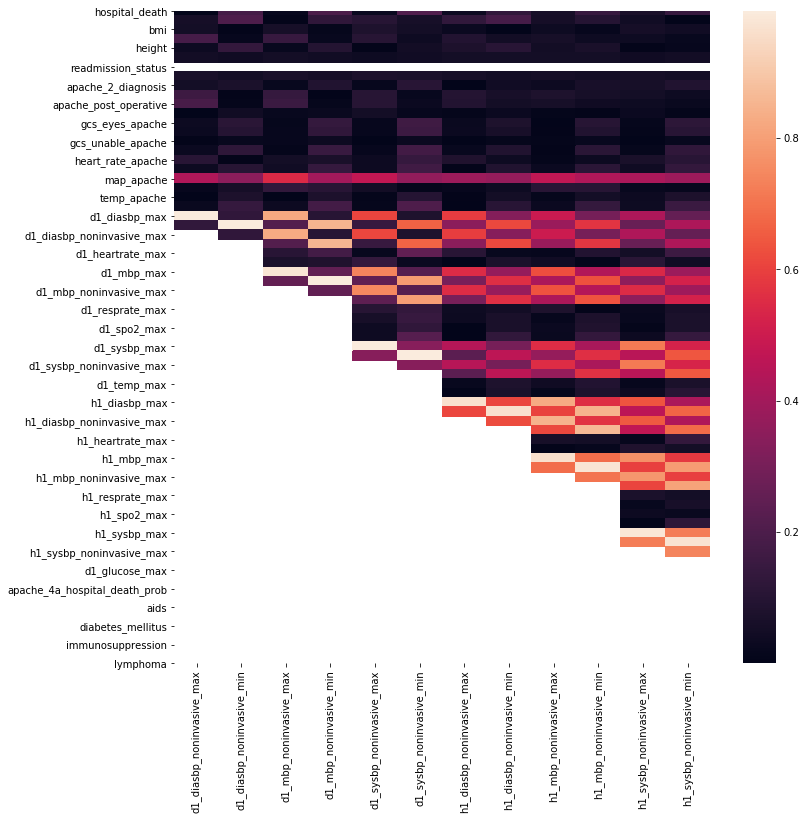

In [58]:
plt.figure(figsize=(12,12))

sns.heatmap(upper[to_drop])

In [59]:
# drop highly correlated features #revisit

training.drop(columns=to_drop, inplace=True)

In [60]:
training

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,0.0,68.0,22.730000,0.0,Caucasian,M,180.3,Floor,admit,CTICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,0.0,77.0,27.420000,0.0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,0.0,25.0,31.950000,0.0,Caucasian,F,172.7,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,0.0,81.0,22.640000,1.0,Caucasian,F,165.1,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,0.0,19.0,29.171191,0.0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91701,0.0,21.0,24.874059,0.0,Caucasian,M,185.4,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91706,0.0,54.0,19.770448,0.0,Native American,M,177.8,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,M
91708,0.0,75.0,23.060250,0.0,Caucasian,M,177.8,Floor,admit,Cardiac ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,M
91709,0.0,56.0,47.179671,0.0,Caucasian,F,183.0,Floor,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,F


## Convert to numerical via labelencoding or onehotencoding #revisit

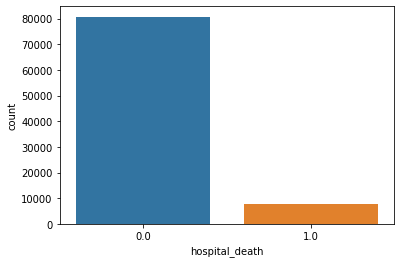

In [61]:
sns.countplot(training.hospital_death)

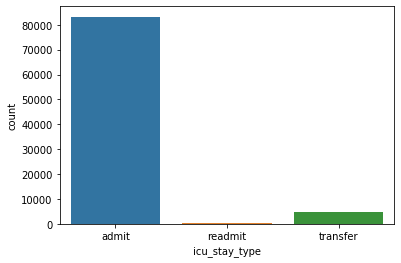

In [62]:
sns.countplot(categorical.icu_stay_type)

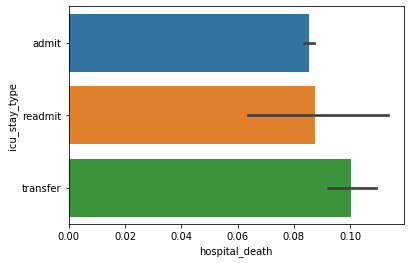

In [63]:
sns.barplot(training.hospital_death, categorical.icu_stay_type)

In [64]:
training

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,0.0,68.0,22.730000,0.0,Caucasian,M,180.3,Floor,admit,CTICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,0.0,77.0,27.420000,0.0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,0.0,25.0,31.950000,0.0,Caucasian,F,172.7,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,0.0,81.0,22.640000,1.0,Caucasian,F,165.1,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,0.0,19.0,29.171191,0.0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91701,0.0,21.0,24.874059,0.0,Caucasian,M,185.4,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91706,0.0,54.0,19.770448,0.0,Native American,M,177.8,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,M
91708,0.0,75.0,23.060250,0.0,Caucasian,M,177.8,Floor,admit,Cardiac ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,M
91709,0.0,56.0,47.179671,0.0,Caucasian,F,183.0,Floor,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,F


In [65]:
training["hospital_death"].sum()

7621.0

In [66]:
training.groupby("icu_stay_type")["hospital_death"].sum()

icu_stay_type
admit       7110.0
readmit       44.0
transfer     467.0
Name: hospital_death, dtype: float64

In [67]:
training.groupby("icu_stay_type")["hospital_death"].mean()*100

icu_stay_type
admit        8.544235
readmit      8.747515
transfer    10.043011
Name: hospital_death, dtype: float64

In [68]:
categorical.head(30)

,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,Caucasian,M,Floor,admit,CTICU,Sepsis,Cardiovascular,M
1,Caucasian,F,Floor,admit,Med-Surg ICU,Respiratory,Respiratory,F
2,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic,F
3,Caucasian,F,Operating Room / Recovery,admit,CTICU,Cardiovascular,Cardiovascular,F
4,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,Trauma,Trauma,M
5,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,Neurological,Neurologic,M
6,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU,Respiratory,Respiratory,F
7,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,Sepsis,Cardiovascular,M
8,Caucasian,M,Other Hospital,admit,CCU-CTICU,Cardiovascular,Cardiovascular,M
9,NaN,M,Accident & Emergency,admit,CCU-CTICU,Cardiovascular,Cardiovascular,M


In [69]:
training.shape

(88367, 68)

In [70]:
training_encoded = pd.get_dummies(training.select_dtypes('object'))

In [71]:
training_encoded

,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_F,gender_M,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,...,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses,gender_missing_F,gender_missing_M,gender_missing_Missing
0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,0,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91701,0,0,1,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
91706,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
91708,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
91709,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [72]:
training = training.join(training_encoded)

In [73]:
training.drop(columns=categorical.columns, inplace=True)

In [74]:
training

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,...,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses,gender_missing_F,gender_missing_M,gender_missing_Missing
0,0.0,68.0,22.730000,0.0,180.3,0.541667,0.0,73.900000,113.0,502.01,...,0,0,0,0,0,0,0,0,1,0
1,0.0,77.0,27.420000,0.0,160.0,0.927778,0.0,70.200000,108.0,203.01,...,0,0,0,1,0,0,0,1,0,0
2,0.0,25.0,31.950000,0.0,172.7,0.000694,0.0,95.300000,122.0,703.03,...,1,0,0,0,0,0,0,1,0,0
3,0.0,81.0,22.640000,1.0,165.1,0.000694,0.0,61.700000,203.0,1206.03,...,0,0,0,0,0,0,0,1,0,0
4,0.0,19.0,29.171191,0.0,188.0,0.073611,0.0,83.981228,119.0,601.01,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91701,0.0,21.0,24.874059,0.0,185.4,0.052083,0.0,85.500000,123.0,702.01,...,1,0,0,0,0,0,0,0,1,0
91706,0.0,54.0,19.770448,0.0,177.8,0.025694,0.0,62.500000,109.0,108.01,...,0,0,0,0,0,0,0,0,1,0
91708,0.0,75.0,23.060250,0.0,177.8,0.298611,0.0,72.900000,113.0,501.06,...,0,0,0,0,0,0,0,0,1,0
91709,0.0,56.0,47.179671,0.0,183.0,0.120139,0.0,158.000000,113.0,501.05,...,0,0,0,0,0,0,0,1,0,0


In [75]:
training.dtypes.value_counts()

float64    60
uint8      48
dtype: int64

In [76]:
training_backup = training.copy()

In [77]:
training_backup.shape

(88367, 108)

In [78]:
training = training_backup.copy()

## scale data

In [79]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

# scaler.fit_transform(training)

In [80]:
## decoded to scale egverything #revisit

# training_to_be_scaled = training.select_dtypes('float')

In [81]:
scaler.fit_transform(numerical)

array([[-0.30721716,  0.33860823, -0.77859195, ..., -0.08480584,
        -0.06440212, -0.14582537],
       [-0.30721716,  0.87485857, -0.2116787 , ..., -0.08480584,
        -0.06440212, -0.14582537],
       [-0.30721716, -2.22347672,  0.33589422, ..., -0.08480584,
        -0.06440212, -0.14582537],
       ...,
       [-0.30721716,  0.75569182, -0.73867229, ..., -0.08480584,
        -0.06440212,  6.8575173 ],
       [-0.30721716, -0.37639222,  2.17681153, ..., -0.08480584,
        -0.06440212, -0.14582537],
       [-0.30721716,  1.17277542, -0.86305477, ..., -0.08480584,
        -0.06440212, -0.14582537]])

In [82]:
training.columns!='hospital_death'

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [83]:
training.columns[training.columns!='hospital_death']

Index(['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days',
       'readmission_status', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'apache_post_operative',
       ...
       'apache_2_bodysystem_Metabolic', 'apache_2_bodysystem_Neurologic',
       'apache_2_bodysystem_Renal/Genitourinary',
       'apache_2_bodysystem_Respiratory', 'apache_2_bodysystem_Trauma',
       'apache_2_bodysystem_Undefined Diagnoses',
       'apache_2_bodysystem_Undefined diagnoses', 'gender_missing_F',
       'gender_missing_M', 'gender_missing_Missing'],
      dtype='object', length=107)

In [84]:
# is there a better way to do this?

training[training.drop(columns='hospital_death').columns] = scaler.fit_transform(training.drop(columns='hospital_death'))

In [85]:
training= training.copy()

In [86]:
mapper.fit_transform?

Object `mapper.fit_transform` not found.


In [87]:
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([(training.columns, StandardScaler())])
scaled_features = mapper.fit_transform(training.copy())
scaled_features_training = pd.DataFrame(scaled_features, index=training.index, columns=training.columns)

In [88]:
scaled_features_training

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,...,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses,gender_missing_F,gender_missing_M,gender_missing_Missing
0,-0.307217,0.345357,-7.930842e-01,-0.475690,0.994481,-0.119813,0.0,-4.091934e-01,-0.842894,-0.121007,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
1,-0.307217,0.892296,-2.156188e-01,-0.475690,-0.899231,0.036226,0.0,-5.593751e-01,-0.901312,-0.768302,...,-0.303985,-0.387798,-0.167122,2.612723,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135
2,-0.307217,-2.267794,3.421463e-01,-0.475690,0.285505,-0.338434,0.0,4.594249e-01,-0.737740,0.314174,...,3.289631,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135
3,-0.307217,1.135380,-8.041656e-01,2.102212,-0.423471,-0.338434,0.0,-9.043871e-01,0.208642,1.403101,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135
4,-0.307217,-2.632420,-1.049182e-16,-0.475690,1.712786,-0.308967,0.0,-3.407352e-16,-0.772791,0.093314,...,-0.303985,-0.387798,-0.167122,-0.382742,4.737037,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91701,-0.307217,-2.510878,-5.290928e-01,-0.475690,1.470242,-0.317667,0.0,6.164643e-02,-0.726056,0.311966,...,3.289631,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
91706,-0.307217,-0.505436,-1.157485e+00,-0.475690,0.761266,-0.328331,0.0,-8.719153e-01,-0.889629,-0.973964,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
91708,-0.307217,0.770754,-7.524215e-01,-0.475690,0.761266,-0.218038,0.0,-4.497831e-01,-0.842894,-0.123064,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
91709,-0.307217,-0.383894,2.217329e+00,-0.475690,1.246355,-0.290163,0.0,3.004395e+00,-0.842894,-0.123086,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135


In [89]:
training


,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,...,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses,gender_missing_F,gender_missing_M,gender_missing_Missing
0,0.0,0.345357,-7.930842e-01,-0.475690,0.994481,-0.119813,0.0,-4.091934e-01,-0.842894,-0.121007,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
1,0.0,0.892296,-2.156188e-01,-0.475690,-0.899231,0.036226,0.0,-5.593751e-01,-0.901312,-0.768302,...,-0.303985,-0.387798,-0.167122,2.612723,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135
2,0.0,-2.267794,3.421463e-01,-0.475690,0.285505,-0.338434,0.0,4.594249e-01,-0.737740,0.314174,...,3.289631,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135
3,0.0,1.135380,-8.041656e-01,2.102212,-0.423471,-0.338434,0.0,-9.043871e-01,0.208642,1.403101,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135
4,0.0,-2.632420,4.374348e-16,-0.475690,1.712786,-0.308967,0.0,-5.768135e-16,-0.772791,0.093314,...,-0.303985,-0.387798,-0.167122,-0.382742,4.737037,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91701,0.0,-2.510878,-5.290928e-01,-0.475690,1.470242,-0.317667,0.0,6.164643e-02,-0.726056,0.311966,...,3.289631,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
91706,0.0,-0.505436,-1.157485e+00,-0.475690,0.761266,-0.328331,0.0,-8.719153e-01,-0.889629,-0.973964,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
91708,0.0,0.770754,-7.524215e-01,-0.475690,0.761266,-0.218038,0.0,-4.497831e-01,-0.842894,-0.123064,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
91709,0.0,-0.383894,2.217329e+00,-0.475690,1.246355,-0.290163,0.0,3.004395e+00,-0.842894,-0.123086,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135


## EDA

Start with DABL

Custom Plots

In [90]:
import dabl

In [91]:
dabl.plot?

Signature:
dabl.plot(
    X,
    y=None,
    target_col=None,
    type_hints=None,
    scatter_alpha='auto',
    scatter_size='auto',
    verbose=10,
    plot_pairwise=True,
    **kwargs,
)
Docstring:
Automatic plots for classification and regression.

Determines whether the target is categorical or continuous and plots the
target distribution. Then calls the relevant plotting functions
accordingly.


Parameters
----------
X : DataFrame
    Input features. If target_col is specified, X also includes the
    target.
y : Series or numpy array, optional.
    Target. You need to specify either y or target_col.
target_col : string or int, optional
    Column name of target if included in X.
type_hints : dict or None
    If dict, provide type information for columns.
    Keys are column names, values are types as provided by detect_types.
scatter_alpha : float, default='auto'
    Alpha values for scatter plots. 'auto' is dirty hacks.
scatter_size : float, default='auto'.
    Marker size for 

C:\Users\Anthony\Anaconda3\lib\site-packages\dabl\preprocessing.py:318: UserWarning: Discarding near-constant features: ['readmission_status', 'arf_apache', 'gcs_unable_apache', 'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'ethnicity_Asian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown', 'icu_admit_source_Other Hospital', 'icu_admit_source_Other ICU', 'icu_stay_type_readmit', 'icu_type_CTICU', 'apache_3j_bodysystem_Genitourinary', 'apache_3j_bodysystem_Gynecological', 'apache_3j_bodysystem_Hematological', 'apache_3j_bodysystem_Musculoskeletal/Skin', 'apache_3j_bodysystem_Trauma', 'apache_2_bodysystem_Haematologic', 'apache_2_bodysystem_Renal/Genitourinary', 'apache_2_bodysystem_Trauma', 'apache_2_bodysystem_Undefined Diagnoses', 'apache_2_bodysystem_Undefined diagnoses', 'gender_missing_Missing']
  near_constant.index[near_constant].tolist()))


Target looks like classification
Showing only top 10 of 44 continuous features


C:\Users\Anthony\Anaconda3\lib\site-packages\dabl\plot\utils.py:621: UserWarning: Dropped 380 outliers in column d1_spo2_min.
  int(dropped), series.name), UserWarning)


Linear Discriminant Analysis training set score: 0.654
Showing only top 10 of 34 categorical features


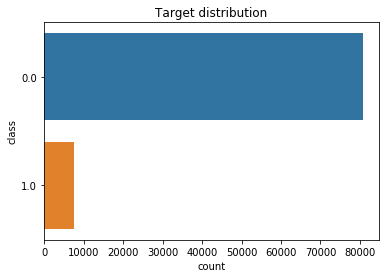

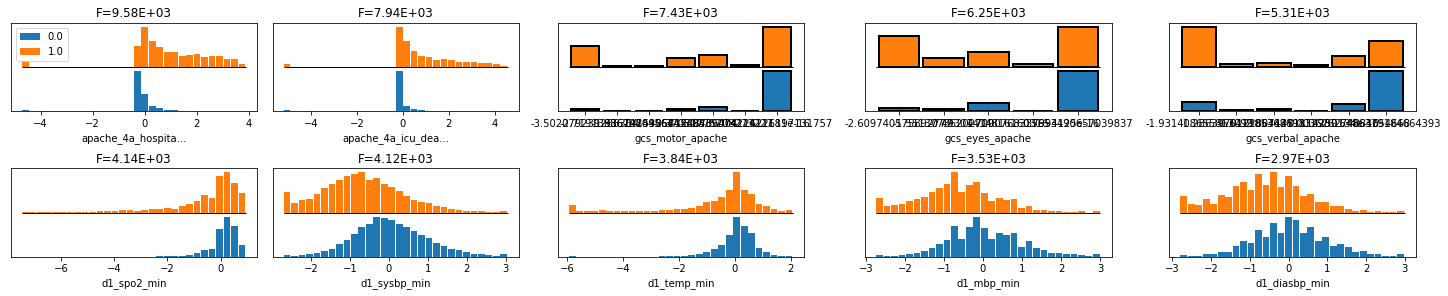

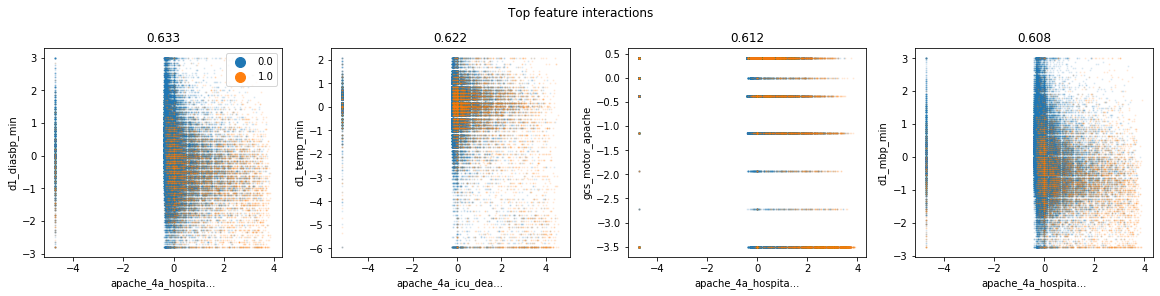

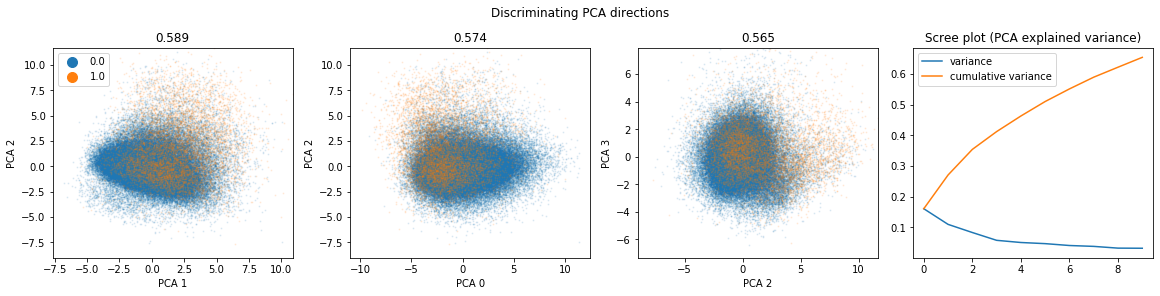

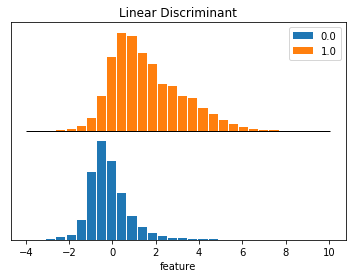

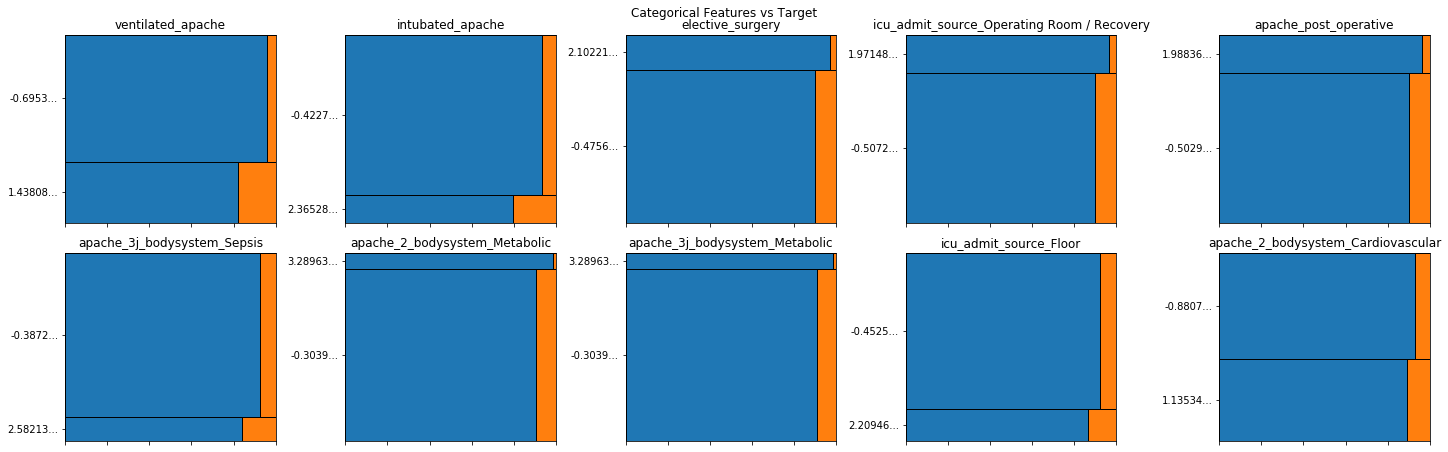

In [92]:
dabl.plot(training, target_col="hospital_death")


In [93]:
# Instantiate the library
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


In [94]:
AV.AutoViz?

Signature:
AV.AutoViz(
    filename,
    sep=',',
    depVar='',
    dfte=None,
    header=0,
    verbose=0,
    lowess=False,
    chart_format='svg',
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
)
Docstring:
##############################################################################
##### AUTOVIZ PERFORMS AUTOMATIC VISUALIZATION OF ANY DATA SET WITH ONE CLICK.
#####    Give it any input file (CSV, txt or json) and AV will visualize it.##
##### INPUTS:                                                            #####
#####    A FILE NAME OR A DATA FRAME AS INPUT.                           #####
##### AutoViz will visualize any sized file using a statistically valid sample.
#####  - max_rows_analyzed = 150000 ### this limits the max number of rows ###
#####           that is used to display charts                             ###
#####  - max_cols_analyzed = 30  ### This limits the number of continuous  ###
#####           vars that can be analyzed                           

In [95]:
training

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,...,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses,gender_missing_F,gender_missing_M,gender_missing_Missing
0,0.0,0.345357,-7.930842e-01,-0.475690,0.994481,-0.119813,0.0,-4.091934e-01,-0.842894,-0.121007,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
1,0.0,0.892296,-2.156188e-01,-0.475690,-0.899231,0.036226,0.0,-5.593751e-01,-0.901312,-0.768302,...,-0.303985,-0.387798,-0.167122,2.612723,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135
2,0.0,-2.267794,3.421463e-01,-0.475690,0.285505,-0.338434,0.0,4.594249e-01,-0.737740,0.314174,...,3.289631,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135
3,0.0,1.135380,-8.041656e-01,2.102212,-0.423471,-0.338434,0.0,-9.043871e-01,0.208642,1.403101,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135
4,0.0,-2.632420,4.374348e-16,-0.475690,1.712786,-0.308967,0.0,-5.768135e-16,-0.772791,0.093314,...,-0.303985,-0.387798,-0.167122,-0.382742,4.737037,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91701,0.0,-2.510878,-5.290928e-01,-0.475690,1.470242,-0.317667,0.0,6.164643e-02,-0.726056,0.311966,...,3.289631,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
91706,0.0,-0.505436,-1.157485e+00,-0.475690,0.761266,-0.328331,0.0,-8.719153e-01,-0.889629,-0.973964,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
91708,0.0,0.770754,-7.524215e-01,-0.475690,0.761266,-0.218038,0.0,-4.497831e-01,-0.842894,-0.123064,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,-0.923004,0.923488,-0.016135
91709,0.0,-0.383894,2.217329e+00,-0.475690,1.246355,-0.290163,0.0,3.004395e+00,-0.842894,-0.123086,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.06141,-0.205394,1.083419,-1.082851,-0.016135


In [96]:
# trainingt = AV.AutoViz(filename='', depVar='hospital_death', trainingte=training, verbose=2,
#                             lowess=False,chart_format='svg',max_rows_analyzed=1000,max_cols_analyzed=121)

## train test split

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
X = training.iloc[:, 1:]

In [99]:
y = training.iloc[:, 0]

In [100]:
X.shape

(88367, 107)

In [101]:
y.shape

(88367,)

In [102]:
# del X_train, y_train, X_test,  y_test

In [131]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [132]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(70693, 107)
(17674, 107)
(70693,)
(17674,)


In [133]:
X_train

,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,...,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses,gender_missing_F,gender_missing_M,gender_missing_Missing
20659,-0.080040,-0.157102,2.102212,0.639993,0.806032,0.0,0.118472,1.435434,1.405223,1.988362,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,4.868698,-0.923004,0.923488,-0.016135
51183,-0.748520,0.124066,2.102212,-1.925380,-0.158822,0.0,-0.689262,1.435434,2.911991,1.988362,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,4.868698,1.083419,-1.082851,-0.016135
15139,1.317693,-0.569326,-0.475690,-0.656686,-0.266309,0.0,-0.774500,-0.714373,-0.547486,-0.502926,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,-0.205394,-0.923004,0.923488,-0.016135
84979,-0.201581,-1.339196,-0.475690,1.237026,-0.338434,0.0,-0.924682,-0.842894,-0.123064,-0.502926,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,-0.205394,-0.923004,0.923488,-0.016135
78961,0.709983,-0.867378,-0.475690,-0.656686,-0.337873,0.0,-1.034274,1.435434,1.175812,-0.502926,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,16.283908,-0.205394,1.083419,-1.082851,-0.016135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6369,-0.201581,0.319514,2.102212,-1.132447,-0.337031,0.0,-0.210304,1.353648,2.052626,1.988362,...,-0.303985,2.578662,-0.167122,-0.382742,-0.211102,-0.061410,-0.205394,1.083419,-1.082851,-0.016135
56609,1.074609,0.076132,-0.475690,0.994481,0.005635,0.0,0.521933,-0.842894,-0.121007,-0.502926,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,-0.205394,-0.923004,0.923488,-0.016135
79466,-1.842397,-0.203249,-0.475690,0.761266,-0.337873,0.0,0.122531,-0.737740,0.314174,-0.502926,...,3.289631,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,-0.205394,-0.923004,0.923488,-0.016135
876,1.013838,-1.360316,-0.475690,-0.423471,-0.338434,0.0,-1.403640,0.337163,1.825207,1.988362,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,-0.205394,1.083419,-1.082851,-0.016135


## Create Pipeline

In [ ]:
X_train.dtypes.value_counts(*)

In [134]:
## create transformers for pipelione

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## data needs to be at preprocessing stage
# need to undo steps below

# Missing value imputer. Replace NaN with 'missing_value' for categorical fields.
categorical_transformer  = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant'))
                                           ])
# Standardise numerical fields
numeric_transformer = Pipeline([('scaler', StandardScaler()),])

In [135]:
# numeric_features = X_train.select_dtypes(include=['int64', 'float64']).drop('Calculated_Days_Difference', axis=1).columns

# create a list of features with specific data types for processing

numeric_features     = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# change this to include the complement
other_features = X_train.select_dtypes(include=['datetime64', 'uint8']).columns
other_features = X_train.select_dtypes(include=['uint8']).columns

# Assemble categorical and numerical pipelines
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [136]:
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 Index(['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days',
       'readmission_status', 'weight', 'apache_2_diagnosis',
       'apache_3...
       'apache_2_bodysystem_Undefined Diagnoses',
       'apache_2_bodysystem_Undefined diagnoses', 'gender_missing_F',
       'gender_missing_M', 'gender_missing_Missing'],
      dtype='object', length=107)),
                                ('cat

In [137]:
X_train.shape

(70693, 107)

In [138]:
preprocessor.transform(X_train).shape

(70693, 107)

In [139]:
X_train.head()

,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,...,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses,gender_missing_F,gender_missing_M,gender_missing_Missing
20659,-0.080040,-0.157102,2.102212,0.639993,0.806032,0.0,0.118472,1.435434,1.405223,1.988362,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,4.868698,-0.923004,0.923488,-0.016135
51183,-0.748520,0.124066,2.102212,-1.925380,-0.158822,0.0,-0.689262,1.435434,2.911991,1.988362,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,4.868698,1.083419,-1.082851,-0.016135
15139,1.317693,-0.569326,-0.475690,-0.656686,-0.266309,0.0,-0.774500,-0.714373,-0.547486,-0.502926,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,-0.205394,-0.923004,0.923488,-0.016135
84979,-0.201581,-1.339196,-0.475690,1.237026,-0.338434,0.0,-0.924682,-0.842894,-0.123064,-0.502926,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,-0.061410,-0.205394,-0.923004,0.923488,-0.016135
78961,0.709983,-0.867378,-0.475690,-0.656686,-0.337873,0.0,-1.034274,1.435434,1.175812,-0.502926,...,-0.303985,-0.387798,-0.167122,-0.382742,-0.211102,16.283908,-0.205394,1.083419,-1.082851,-0.016135


In [140]:
X_train_processed = preprocessor.transform(X_train)

In [143]:
X_train = pd.DataFrame(X_train_processed, columns=X_train.columns.to_list())

## Model

In [105]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()

In [106]:
import lightgbm as lgb

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [108]:
import xgboost as xgb

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
n_jobs = 2
random_state = 42

In [110]:
# Modeling step Test differents algorithms 
classifiers = []
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(lgb.LGBMClassifier(random_state=random_state))
classifiers.append(xgb.XGBClassifier(random_state=random_state))
# classifiers.append(SVC(random_state=random_state))
# classifiers.append(DecisionTreeClassifier(random_state=random_state))
# classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
# classifiers.append(ExtraTreesClassifier(random_state=random_state))
# classifiers.append(GradientBoostingClassifier(random_state=random_state))
# classifiers.append(MLPClassifier(random_state=random_state))
# classifiers.append(KNeighborsClassifier())
# classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "roc_auc", cv = kfold, n_jobs=n_jobs))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())



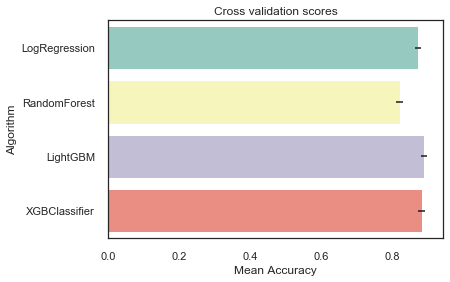

In [111]:
# cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogRegression", "SVC","DecisionTree","AdaBoost",
# "RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LinearDiscriminantAnalysis"]})

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogRegression", "RandomForest", "LightGBM", "XGBClassifier"]})


g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
# g.set_xlabel("Mean Accuracy")
# g = g.set_title("Cross validation scores")
    
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [112]:
cv_res.sort_values('CrossValMeans', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
2,0.888578,0.007751,LightGBM
3,0.881924,0.009602,XGBClassifier
0,0.870193,0.008013,LogRegression
1,0.819260,0.011002,RandomForest


In [113]:
# XGBC Parameters tunning 

XGBC = xgb.XGBClassifier()


## Search grid for optimal parameters
XGBC_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsXGBC = GridSearchCV(XGBC, param_grid = XGBC_param_grid, cv=kfold, scoring="roc_auc", n_jobs=n_jobs, verbose = 1)

gsXGBC.fit(X_train,Y_train)

XGBC_best = gsXGBC.best_estimator_

# Best score
gsXGBC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.2min


KeyboardInterrupt: 

In [ ]:
# LGBM Parameters tunning 
LGBM = lgb.LGBMClassifier()


## Search grid for optimal parameters
LGBM_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsLGBM = GridSearchCV(LGBM, param_grid = LGBM_param_grid, cv=kfold, scoring="roc_auc", n_jobs=n_jobs, verbose = 1)

gsLGBM.fit(X_train,Y_train)

LGBM_best = gsLGBM.best_estimator_

# Best score
gsLGBM.best_score_

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring="roc_auc", n_jobs=n_jobs, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
%timeit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLGBM.best_estimator_,"LGBM mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsXGBC.best_estimator_,"XGBC mearning curves",X_train,Y_train,cv=kfold)


In [ ]:
# nrows = 1
# ncols = 1

nrows = 2
ncols = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

# names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]
names_classifiers = [("RandomForest", RFC_best), ("LightGBM", LGBM_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h', ax=axes[row])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [ ]:
names_classifiers = [("RandomForest", RFC_best), ("LightGBM", LGBM_best), ("XGBC", XGBC_best)]

nclassifier = 0

names_classifiers[nclassifier][0]


In [ ]:
names_classifiers[nclassifier][1]


In [ ]:
nclassifier = 1

names_classifiers[nclassifier][0]

In [ ]:
names_classifiers[nclassifier][1]

In [ ]:
axes[0]

In [ ]:
name = names_classifiers[0][0]
classifier = names_classifiers[0][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

In [ ]:
name = names_classifiers[1][0]
classifier = names_classifiers[1][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

In [ ]:
name = names_classifiers[2][0]
classifier = names_classifiers[2][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

In [ ]:
# Need to align test set with train

In [ ]:
X_train.columns.to_list()

apply all preprocesing steps to test data frame

drop id fields
drop missing columns
drop missing rows
fill nas / impute missing values
- categorical, mode
- numerical, mean
multicollinearity threshold > 0.95
one hot encode categorical fields
scale all day except for target label



In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
# test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
# test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
# test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
# test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_LGBM = pd.Series(LGBM_best.predict(test), name="LGBM")
test_Survived_XGBC = pd.Series(XGBC_best.predict(test), name="XGBC")


# Concatenate all classifier results
# ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_LGBM, test_Survived_XGBC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

In [ ]:
end_time = datetime.now()

In [ ]:
print(end_time - start_time)